# TensorFlow Classification - Exercises

Classification Test Set (Titanic Data Set)

https://www.kaggle.com/datasets/brendan45774/test-file

#### *Connect to Kaggle from Google Colab*

- https://stackoverflow.com/questions/56816537/cant-find-kaggle-json-file-in-google-colab

In [2]:
# Import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix






# Type your code above this line

In [3]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"username","key":"api-key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d brendan45774/test-file

  0% 0.00/11.2k [00:00<?, ?B/s]
100% 11.2k/11.2k [00:00<00:00, 9.67MB/s]


In [5]:
import zipfile

zip_file = zipfile.ZipFile('test-file.zip')
zip_file.extractall()
zip_file.close()

### Load data and create DataFrame

In [13]:
df = pd.read_csv('tested.csv')

In [9]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,0,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,0,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


### Data Cleanup

Fill in all the NA's of the age column
- Avg age of NA's in Class1: 41
- Avg age of NA's in Class2: 29
- Avg age of NA's in Class3: 24

OneHotEncode (get_dummies)
- Embarked
- Pclass

Drop the unnecessary colums
- Pclass, Embarked, Name, Cabin, Sex, Ticket, PassengerID

Drop any other NA values

In [10]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [14]:
def fill_in_age(cols):
  age = cols[0]
  pclass = cols[1]

  if np.isnan(age):
    if pclass == 1:
      return 41
    elif pclass == 2:
      return 29
    else:
      return 24
  else:
    return age


df['Age'] = df[['Age', 'Pclass']].apply(fill_in_age, axis=1)


embarked = pd.get_dummies(df['Embarked'], drop_first=True)
pclass = pd.get_dummies(df['Pclass'], drop_first=True).rename({2:'P2',3:'P3'}, axis=1)


df = pd.concat([df, pclass, embarked], axis=1)

df = df.drop(['PassengerId','Pclass', 'Embarked', 'Sex', 'Name', 'Ticket', 'Cabin'], axis=1)

df = df.dropna()

df

,Survived,Age,SibSp,Parch,Fare,P2,P3,Q,S
0,0,34.5,0,0,7.8292,0,1,1,0
1,1,47.0,1,0,7.0000,0,1,0,1
2,0,62.0,0,0,9.6875,1,0,1,0
3,0,27.0,0,0,8.6625,0,1,0,1
4,1,22.0,1,1,12.2875,0,1,0,1
...,...,...,...,...,...,...,...,...,...
413,0,24.0,0,0,8.0500,0,1,0,1
414,1,39.0,0,0,108.9000,0,0,0,0
415,0,38.5,0,0,7.2500,0,1,0,1
416,0,24.0,0,0,8.0500,0,1,0,1


### Train Test Split and Scale

In [15]:
X = df[df.columns[1:]].values

y = df['Survived'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [16]:
# Min Max Scaler

mm = MinMaxScaler()

X_train = mm.fit_transform(X_train)
X_test = mm.transform(X_test)

In [18]:
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

### TensorBoard Configuration

In [20]:
# def tb(desc):
#   return TensorBoard(
#     log_dir='tf_logs/' \
#     + desc \
#     + '_' \
#     + datetime.datetime.now().strftime('%Y%m%d_%H:%M:%S')
# )
  
tb = lambda desc: TensorBoard(
    log_dir='tf_logs/' \
    + desc \
    + '_' \
    + datetime.datetime.now().strftime('%Y%m%d_%H:%M:%S'))


### Build Model

3 Hidden Layers
- Activation **relu**
- 8 Units per layer

Compiler
- Optimizer: Adam
- Loss: binary_crossentropy
- Metric: accuracy

Callbacks
- TensorBoard
- EarlyStopping

In [22]:
model_1 = Sequential()

model_1.add(Dense(8, activation='relu'))
model_1.add(Dense(8, activation='relu'))
model_1.add(Dense(8, activation='relu'))

model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)



history_1 = model_1.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=250,
    callbacks=[es, tb('model_1')]
)

Epoch 1/250
10/10 [==============================] - 2s 43ms/step - loss: 0.7051 - accuracy: 0.4502 - val_loss: 0.6854 - val_accuracy: 0.4841
Epoch 2/250
10/10 [==============================] - 0s 9ms/step - loss: 0.6934 - accuracy: 0.5361 - val_loss: 0.6797 - val_accuracy: 0.5952
Epoch 3/250
10/10 [==============================] - 0s 9ms/step - loss: 0.6852 - accuracy: 0.6323 - val_loss: 0.6772 - val_accuracy: 0.6825
Epoch 4/250
10/10 [==============================] - 0s 9ms/step - loss: 0.6804 - accuracy: 0.6186 - val_loss: 0.6747 - val_accuracy: 0.6746
Epoch 5/250
10/10 [==============================] - 0s 9ms/step - loss: 0.6753 - accuracy: 0.6426 - val_loss: 0.6721 - val_accuracy: 0.6429
Epoch 6/250
10/10 [==============================] - 0s 13ms/step - loss: 0.6700 - accuracy: 0.6564 - val_loss: 0.6701 - val_accuracy: 0.6508
Epoch 7/250
10/10 [==============================] - 0s 10ms/step - loss: 0.6655 - accuracy: 0.6357 - val_loss: 0.6683 - val_accuracy: 0.6508
Epoch 8/25

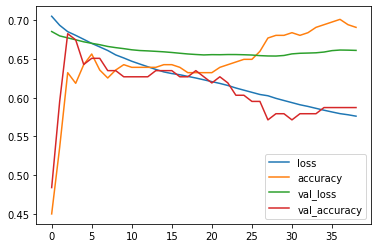

In [23]:
pd.DataFrame(history_1.history).plot()

In [26]:
def plot_losses(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']


  plt.plot(loss, label='loss')
  plt.plot(val_loss, label='val_loss')
  plt.title("Losses")
  plt.legend()

  plt.figure()
  plt.plot(accuracy, label='acc')
  plt.plot(val_accuracy, label='val_acc')
  plt.title('Accuracy')
  plt.legend()

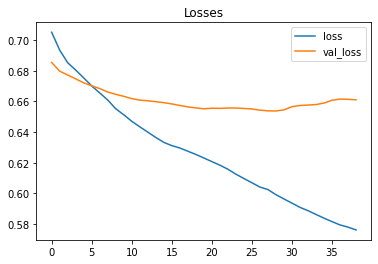

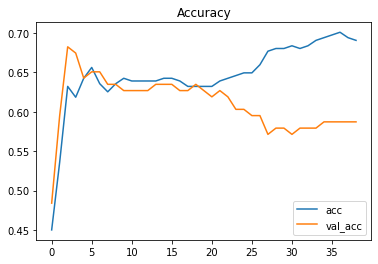

In [27]:
plot_losses(history_1)

### Model 2 - Add Dropout - Prevent Overfitting

Add a dropout layer at 50% drop rate after every Hidden Dense Layer



In [28]:
model_2 = Sequential()

model_2.add(Dense(8, activation='relu', name='DenseLayer1'))
model_2.add(Dropout(0.5, name='DropoutLayer1'))

model_2.add(Dense(8, activation='relu', name='DenseLayer2'))
model_2.add(Dropout(0.5, name='DropoutLayer2'))

model_2.add(Dense(8, activation='relu', name='DenseLayer3'))
model_2.add(Dropout(0.5, name='DropoutLayer3'))


model_2.add(Dense(1, activation='sigmoid'))

model_2.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

history_2 = model_2.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=250,
    callbacks=[es, tb('model_2_dropout')]
)

Epoch 1/250
10/10 [==============================] - 1s 34ms/step - loss: 0.9792 - accuracy: 0.4880 - val_loss: 0.8307 - val_accuracy: 0.3968
Epoch 2/250
10/10 [==============================] - 0s 11ms/step - loss: 1.0263 - accuracy: 0.4605 - val_loss: 0.7993 - val_accuracy: 0.4206
Epoch 3/250
10/10 [==============================] - 0s 10ms/step - loss: 0.9930 - accuracy: 0.5155 - val_loss: 0.7729 - val_accuracy: 0.4206
Epoch 4/250
10/10 [==============================] - 0s 11ms/step - loss: 1.1436 - accuracy: 0.5052 - val_loss: 0.7514 - val_accuracy: 0.4286
Epoch 5/250
10/10 [==============================] - 0s 10ms/step - loss: 0.9811 - accuracy: 0.5052 - val_loss: 0.7349 - val_accuracy: 0.4206
Epoch 6/250
10/10 [==============================] - 0s 11ms/step - loss: 0.9223 - accuracy: 0.4777 - val_loss: 0.7227 - val_accuracy: 0.4127
Epoch 7/250
10/10 [==============================] - 0s 16ms/step - loss: 0.8363 - accuracy: 0.5223 - val_loss: 0.7116 - val_accuracy: 0.4206
Epoch 

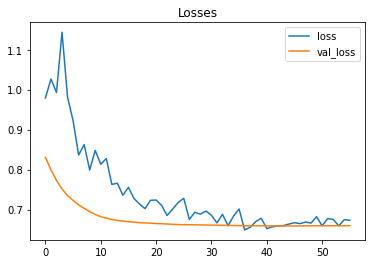

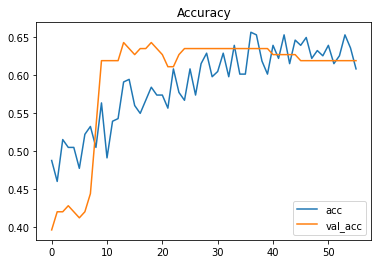

In [29]:
plot_losses(history_2)

### Model 3 - Reduce the Units - Reduce Units

Reduce the number of units to 4 for each Hidden Layer

In [32]:
model_3 = Sequential()

model_3.add(Dense(4, activation='relu'))
model_3.add(Dense(4, activation='relu'))
model_3.add(Dense(4, activation='relu'))

model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

history_3 = model_3.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=250,
    callbacks=[es, tb('model_3_4units')]
)

Epoch 1/250
10/10 [==============================] - 1s 38ms/step - loss: 0.6776 - accuracy: 0.6254 - val_loss: 0.7757 - val_accuracy: 0.5159
Epoch 2/250
10/10 [==============================] - 0s 10ms/step - loss: 0.6701 - accuracy: 0.6392 - val_loss: 0.7675 - val_accuracy: 0.5079
Epoch 3/250
10/10 [==============================] - 0s 10ms/step - loss: 0.6639 - accuracy: 0.6460 - val_loss: 0.7627 - val_accuracy: 0.5159
Epoch 4/250
10/10 [==============================] - 0s 10ms/step - loss: 0.6592 - accuracy: 0.6426 - val_loss: 0.7560 - val_accuracy: 0.5079
Epoch 5/250
10/10 [==============================] - 0s 9ms/step - loss: 0.6547 - accuracy: 0.6529 - val_loss: 0.7488 - val_accuracy: 0.5238
Epoch 6/250
10/10 [==============================] - 0s 9ms/step - loss: 0.6509 - accuracy: 0.6598 - val_loss: 0.7444 - val_accuracy: 0.5317
Epoch 7/250
10/10 [==============================] - 0s 10ms/step - loss: 0.6483 - accuracy: 0.6667 - val_loss: 0.7401 - val_accuracy: 0.5397
Epoch 8/

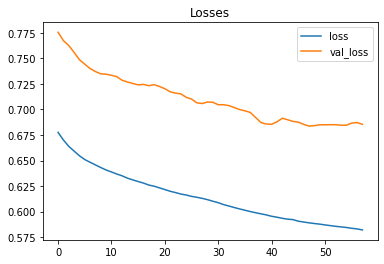

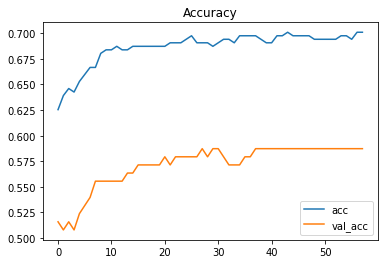

In [33]:
plot_losses(history_3)


In [34]:
model_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 4)                 36        
                                                                 
 dense_13 (Dense)            (None, 4)                 20        
                                                                 
 dense_14 (Dense)            (None, 4)                 20        
                                                                 
 dense_15 (Dense)            (None, 1)                 5         
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [35]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DenseLayer1 (Dense)         (None, 8)                 72        
                                                                 
 DropoutLayer1 (Dropout)     (None, 8)                 0         
                                                                 
 DenseLayer2 (Dense)         (None, 8)                 72        
                                                                 
 DropoutLayer2 (Dropout)     (None, 8)                 0         
                                                                 
 DenseLayer3 (Dense)         (None, 8)                 72        
                                                                 
 DropoutLayer3 (Dropout)     (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [36]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


### Predictions

Comapre the 3 models accuracy rates

Run predictions on the best one

Change the prediction values to be 0 or 1 instead of float values

In [37]:
model_1.evaluate(X_test, y_test)

4/4 [==============================] - 0s 3ms/step - loss: 0.6610 - accuracy: 0.5873


[0.6610180139541626, 0.5873016119003296]

In [38]:
model_2.evaluate(X_test, y_test)

4/4 [==============================] - 0s 5ms/step - loss: 0.6596 - accuracy: 0.6190


[0.6595885753631592, 0.6190476417541504]

In [40]:
model_3.evaluate(X_test, y_test)

4/4 [==============================] - 0s 4ms/step - loss: 0.6855 - accuracy: 0.5873


[0.68548184633255, 0.5873016119003296]

In [41]:
prediction_2 = (model_2.predict(X_test) > 0.5) * 1

In [42]:
confusion_matrix(y_test, prediction_2)

array([[78,  0],
       [48,  0]])

In [43]:
print(classification_report(y_test, prediction_2))

              precision    recall  f1-score   support

           0       0.62      1.00      0.76        78
           1       0.00      0.00      0.00        48

    accuracy                           0.62       126
   macro avg       0.31      0.50      0.38       126
weighted avg       0.38      0.62      0.47       126



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Tensorboard

Upload Data to Google TensorBoard
- Requires auth with Google account
- Will be public for everyone to see
- Do not upload private or sensitive data

Delete your Tensorboard before closing the notebook

In [ ]:
!tensorboard dev upload --logdir tf_logs --one_shot